## Introduction

In today's digital world, chatbots, virtual assistants, and customer support systems depend on **intent recognition** to provide quick and accurate responses. This technology helps AI understand what users really mean when they type a message. For example, if a customer asks, "*How could I get my money back?*", the system can recognize their intent as `get_refund` and provide relevant instructions.

One of the most effective approaches for intent detection is fine-tuning `RoBERTa`, an improved version of `BERT` (developed by Googgle AI). `BERT` enables models to understand context in a way that mimics human comprehension. `RoBERTa` (improved by Meta) takes this further by refining BERT’s training process, making it faster and better at grasping nuanced customer queries.

In this blog, I use `RoBERTa` to do intent detection for a Customer support dataset. This approach is a bit overkill as the dataset is not large, but try to show how to fine-tune `RoBERTa` to do a specific task.

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import os
import random
warnings.filterwarnings('ignore')

c:\TuanTA\ML Projects\NLP Projects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## What is BERT?
BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based machine learning model for natural language processing (NLP) developed by Google. BERT is designed to understand the context of words in a sentence by looking at the words that come before and after them, which is a significant improvement over previous models that only looked at text in one direction.

#### **Architecture**
BERT is based on the Transformer architecture, which relies heavily on **self-attention mechanisms**, which allow the model to weigh the importance of different words in a sentence when encoding a particular word.

#### **Word Embeddings**
Traditional word embeddings like Word2Vec, GloVe create a single dense vector representation for each word, regardless of context. The word "bank" would have the same embedding whether it refers to a financial institution or a river bank. BERT, on the other hand, generates **contextualized word embeddings**, where the same word can have different embeddings depending on the context. The embedding for a word is influenced by all the other words in the sentence, not just the word itself. The word "bank" would have different embeddings in the sentences "I went to the bank to deposit money" and "The river bank is muddy".

#### **Sentence Embeddings**
BERT can also generate embeddins for entire sentences. Special token [CLS] is added at the beginning of every input sentence. The [CLS] token's embedding is often used as a **representation of the entire sentence**, especially in classification tasks. The [SEP] token is used to separate sentences.

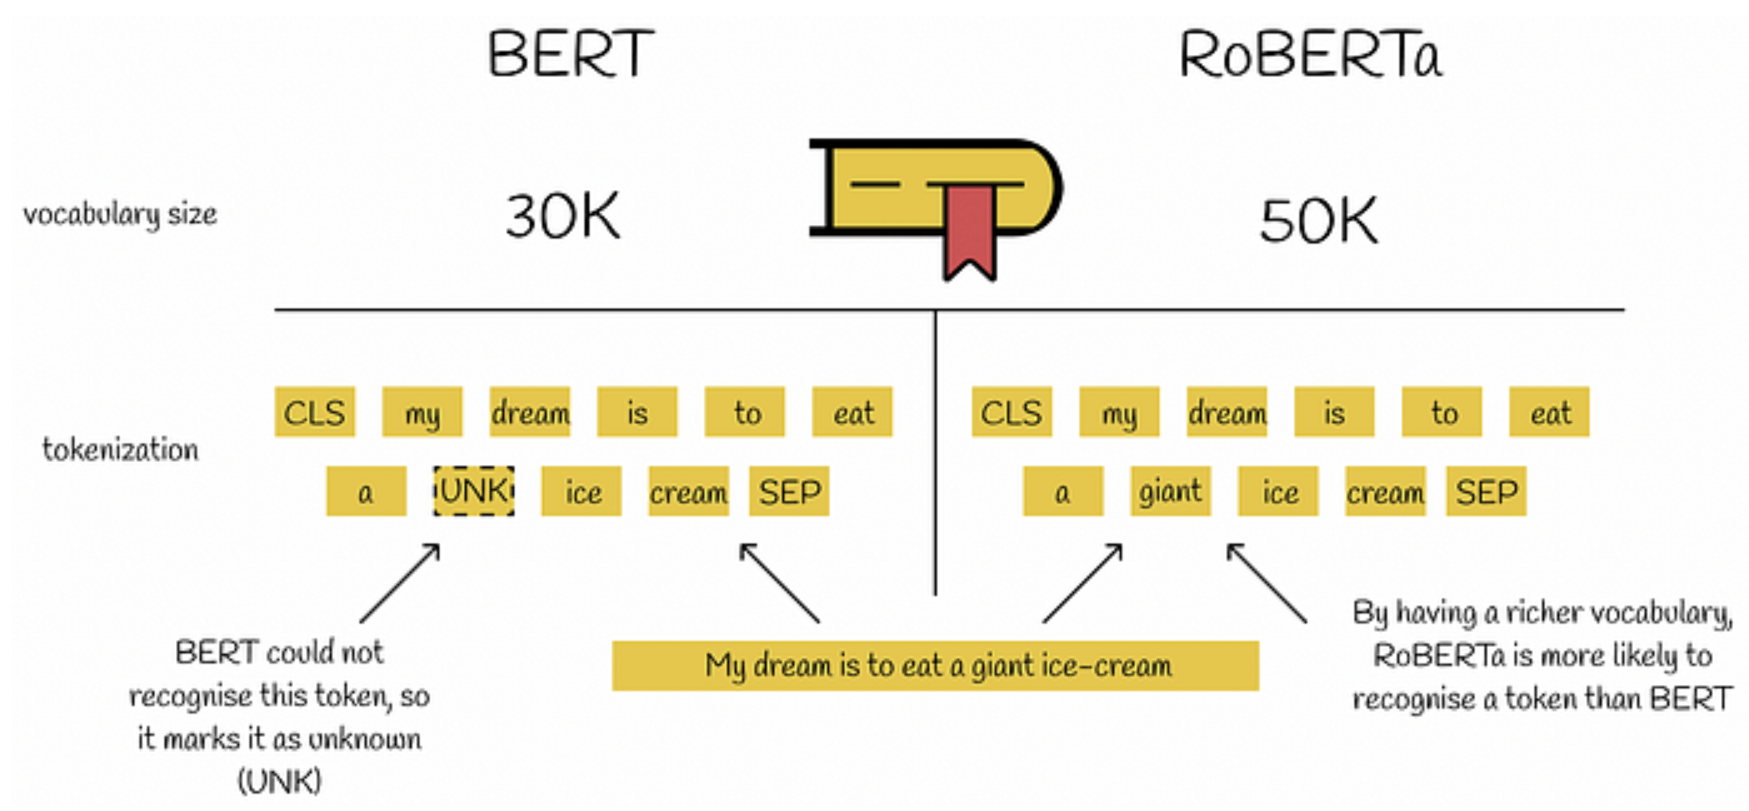

Image by Vyacheslav Efimov

## What is RoBERTa?
`RoBERTa` (Robustly Optimized BERT Pretraining Approach) is essentially a refined and improved version of `BERT` (not a completely new architecture). Both are transformer-based language models.

#### **Key Differences and Improvements**
- More data: `RoBERTa` is trained on a significantly larger dataset (160GB of text) compared to `BERT` (16GB), which allows `RoBERTa` to learn more robust and generalizable language representations.
- Removed Next Sentence Prediction (NSP) task (as in `BERT`)
- Dynamic masking: `RoBERTa` uses dynamic masking, where the masking pattern is changed for each training instance. This forces the model to learn from a more diverse set of masked words.
- `RoBERTa` is trained with larger batch sizes and longer sequences, which allows the model to capture longer-range dependencies in text.
- `RoBERTa` uses a larger byte-level BPE vocabulary (50K subword units) compared to `BERT` (30K). This allows it to handle a wider range of words and subword units, including rare words and misspellings.

#### **Version**
`RoBERTa` comes in two main versions `RoBERTa-Base` and `RoBERTa-Large`. As the language of our dataset is not complex, we use `RoBERTa-Base` which has 123 million parameters.

#### **Transfer Learning**
`RoBERTa` is first pre-trained on a large corpus of text, and then the pre-trained model can be fine-tuned on a wide range of NLP tasks with task-specific data, like intent recoginition in this notebook.

## Data Understanding

To train our intent recognition model, we use a customer support dataset from Kaggle, which can be found [here](https://www.kaggle.com/datasets/scodepy/customer-support-intent-dataset/data). The dataset contains labeled examples of customer queries along with their corresponding intent categories.

The dataset is divided into three parts:

- data_train.csv – Used for training the model, 6539 records.
- data_validation.csv – Used for tuning hyperparameters and validating performance, 818 records.
- data_test.csv – Used to evaluate the final model's accuracy, 818 records.

Each dataset consists of four key features:
- utterance - The actual text input from the user (e.g., "How can I cancel my order?").
- intent – The target label representing the user's intent (e.g., `cancel_order`).
- category – A broader classification of the intent (not used in model training).
- tags – Additional metadata (not used in model training).

For our model, we will focus on the utterance (as input) and the intent (as the target variable).

Notice that the longest utterance is 60 words, which is "can you give me information about a shipping address change?"

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# project_folder = '/content/drive/MyDrive/Colab Notebooks/2025.02.07 Intent Detection'
# df_train_raw = pd.read_csv(f"{project_folder}/dataset/data_train.csv") 
# df_val_raw = pd.read_csv(f"{project_folder}/dataset/data_validation.csv")
# df_test_raw = pd.read_csv(f"{project_folder}/dataset/data_test.csv") 

In [ ]:
df_train_raw = pd.read_csv("dataset/data_train.csv") 
df_val_raw = pd.read_csv("dataset/data_validation.csv")
df_test_raw = pd.read_csv("dataset/data_test.csv")

print(f"Training data shape: {df_train_raw.shape}")
print(f"Validation data shape: {df_val_raw.shape}")
print(f"Test data shape: {df_test_raw.shape}")

longest_utterance = df_train_raw['utterance'].str.len().idxmax()
# Print the longest string
print("Longest utterance:", df_train_raw.loc[longest_utterance, 'utterance'])
print(f"Longest utterance: {len(df_train_raw.loc[longest_utterance, 'utterance'])}")

# Group by 'intent' and get the first 'utterance' for each group
first_utterances = df_train_raw.groupby('intent')['utterance'].first()

# Print the first utterance for each intent
for intent, utterance in first_utterances.items():
    print(f"{intent} - {utterance}")

Training data shape: (6539, 4)
Validation data shape: (818, 4)
Test data shape: (818, 4)
Longest utterance: can you give me information about a shipping address change?
Longest utterance: 60
cancel_order - would it be possible to cancel the order I made?
change_order - problems with adding an item to an order
change_shipping_address - I want help to change the shipping address
check_cancellation_fee - cancellation fee
check_invoice - assistance checking the invoice from two purchases ago
check_payment_methods - i dont know how i can see the payment options
check_refund_policy - help me check how long refunds usually take
complaint - I try to file a complaint against your company
contact_customer_service - I need to check at what time customer service available is
contact_human_agent - I have got to talk to an agent
create_account - how to register?
delete_account - I would like to know about a user account deletion
delivery_options - problem with the options for delivery
delivery_perio

**Intent Categories**

The dataset includes 27 unique intents, covering a range of common customer support queries, such as `cancel_order`, `change_order`, `change_shipping_address`, `create_account`, `delivery_options`, etc.

**Intent Distribution**

To understand how the intents are distributed in the dataset, we plot the intent frequency distribution from the training data. The distribution appears fairly balanced, meaning most intents have a similar number of examples, which helps in training a more generalizable model.

In [4]:
unique_intents = df_train_raw['intent'].unique()
num_unique_intents = df_train_raw['intent'].nunique()

print(f"Number of unique intents: {num_unique_intents}")
print(f"Unique intents: {unique_intents}")

Number of unique intents: 27
Unique intents: ['cancel_order' 'change_order' 'change_shipping_address'
 'check_cancellation_fee' 'check_invoice' 'check_payment_methods'
 'check_refund_policy' 'complaint' 'contact_customer_service'
 'contact_human_agent' 'create_account' 'delete_account'
 'delivery_options' 'delivery_period' 'edit_account' 'get_invoice'
 'get_refund' 'newsletter_subscription' 'payment_issue' 'place_order'
 'recover_password' 'registration_problems' 'review'
 'set_up_shipping_address' 'switch_account' 'track_order' 'track_refund']


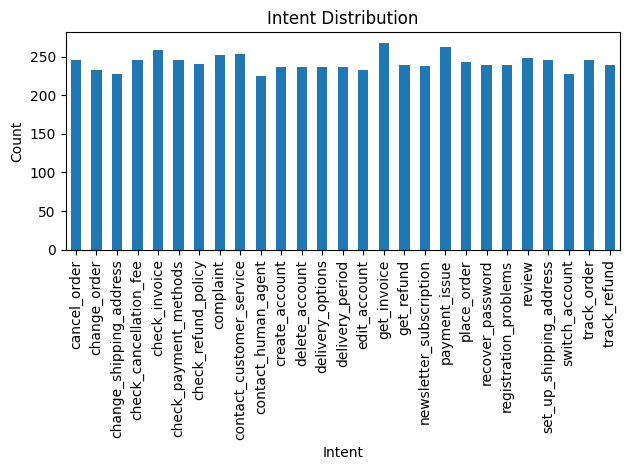

In [5]:
df_train_raw.groupby(['intent']).size().plot.bar()

# Add labels and title (optional)
plt.xlabel('Intent')
plt.ylabel('Count')
plt.title('Intent Distribution')

# Display the plot
plt.tight_layout()  # Ensures labels fit properly
plt.show()

### Data Preprocessing

Given the relatively simple linguistic structure of the text data, I skipped   lemmatizing and stemming. It took much longer and didn't actually make the results any better. The data preprocessing step is simple as converting everything to lowercase and removing common "stop words" like "the," "a," and "is" — basically, words that don't carry much meaning on their own.

For example, "*would it be possible to cancel the order I made?*" becomes "*would possible cancel order made?*" This way, the model gets to work with the important words only.

In [6]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def preprocess_text(text):
    # Convert to lowercase and split into words based on whitespace
    words = text.lower().split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Join words back into a single string
    return ' '.join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fam2064\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Apply preprocessing to the raw text data
df_train = df_train_raw.copy()
df_val = df_val_raw.copy()
df_train['utterance'] = df_train_raw['utterance'].apply(preprocess_text)
df_val['utterance'] = df_val_raw['utterance'].apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
# fit_transform() on training data only, transform() on validation/test data
df_train['encoded_intent'] = label_encoder.fit_transform(df_train_raw['intent'])
df_val['encoded_intent'] = label_encoder.transform(df_val_raw['intent'])

# Split data (after preprocessing)
train_texts = df_train['utterance'].values
train_intents = df_train['encoded_intent'].values
val_texts = df_val['utterance'].values
val_intents = df_val['encoded_intent'].values

## Fine-Tuning RoBERTa

To fine-tune RoBERTa for intent recognition, I use the following key parameters:
- Maximum sequence length for tokenization: Since the longest utterance in our dataset is 60 words, I set `max_len`=64 to ensure sufficient coverage while keeping computations efficient.
- Batch size for the training: `batch_size`=16
- Learning rate for optimizer: `learning_rate`=2e-5
- Number of training epochs: `num_epochs`=5
- Dropout rate for the model: `dropout`=0.3
- Number of epochs for early stopping: `patience`=3
- Pre-trained model name: `model_name`="roberta-base"

In [8]:
from types import SimpleNamespace

# Create a SimpleNamespace for configurations
configs = SimpleNamespace(
    max_len=64,           # Maximum sequence length for tokenization  ------ 128
    batch_size=16,        # Batch size for training
    learning_rate=2e-5,   # Learning rate for optimizer
    num_epochs=5,         # Number of training epochs
    dropout=0.3,          # Dropout rate for the model
    patience=3,           # Patience for early stopping
    randam_seed=42,       # Random seed for reproducibility
    model_name="roberta-base"  # Pre-trained model name
)

### IntentDataset
To train the model effectively, we need to define a custom PyTorch Dataset class that handles tokenization, conversion to tensors, and batching.
- Tokenize the text data using `RobertaTokenizer`
- Convert the tokenized data into PyTorch tensors.
- Serve data in batches during training or evaluation.
- `max_len`: The maximum length of the tokenized sequences. Longer sequences will be truncated, and shorter ones will be padded.
- `encode_plus` method performs the following:
  - Adds special tokens (e.g., [CLS], [SEP] for BERT-like models).
  - Truncates or pads the sequence to `max_len`.
  - Returns `input_ids` (token indices) and `attention_mask` (binary mask indicating which tokens are actual words and which are padding).

This custom detaset class is used by PyTorch's `DataLoader` to fetch batches of data during training or evaluation. When the model receives the `input_ids` and `attention_mask`, it processes them to predict the corresponding intent.

In [9]:
class IntentDataset(Dataset):
    def __init__(self, texts, intents, tokenizer, max_len=configs.max_len):
        self.texts = texts
        self.intents = intents
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        intent = self.intents[idx]

        # Tokenize text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'intent': torch.tensor(intent, dtype=torch.long)
        }

### Define IntentClassifier

The IntentClassifier is a custom PyTorch neural network module designed for my intent recognition solution. It's basically a wrapper around a pre-trained `RoBERTa` model, leveraging its powerful language understanding capabilities.
- Unlike traditional models that predict the next word in a sequence, `RobertaModel` outputs embeddings, which represent the input text in a high-dimensional space. So, to do a classification task, we need to add a fully connected layer (`nn.Linear`) on top of RoBERTa model to map the embeddings to intent predictions.
- However, `RobertaForSequenceClassification` is a better way
  + It automatically adds a classification head with a pooler layer (which is missing in `RobertaModel`).
  + It handles loss computation when you provide labels during training.
  + It is optimized for classification, so you don't have to mess around with adding extra layers manually. This means a super simple `forward()` function – basically one line!

During the forward pass, we take the RoBERTa output, run it through the classification head, and get our predictions.  To keep things from overfitting (you know, when the model memorizes the training data instead of learning patterns), we apply dropout to the `[CLS]` token representation.

Speaking of `[CLS]`, that's a special token RoBERTa adds to the beginning of your input.  It's like a "summary" token.  Through RoBERTa's self-attention magic, `[CLS]` gets to pay attention to all the other words in the sentence.  It learns to weigh the important parts, effectively summarizing the whole input for our classification task.

In [ ]:
from transformers import RobertaForSequenceClassification

class IntentClassifier(nn.Module):
    def __init__(self, num_intent_classes, model_name=configs.model_name, dropout=configs.dropout):
        super(IntentClassifier, self).__init__()

        # Store the configuration
        self.config = RobertaConfig.from_pretrained(model_name)
        self.config.num_labels = num_intent_classes
        self.config.dropout = dropout

        # Load the pre-trained model with a classification head
        self.model = RobertaForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_intent_classes,
            hidden_dropout_prob=dropout
        )

    # forward pass to generate predictions
    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask)

### Training the IntentClassifier
Train an instance of the IntentClassifier model using a training data loader and evaluating its performance with a validation data loader. To improve efficiency and stability, I incorporate several best practices like gradient clipping, learning rate scheduling, and early stopping.
- Optimizer: `AdamW` is a variant of Adam with weight decay for better regulation
- Loss Function: `CrossEntropyLoss` suitable for multi-class classification tasks
- Learning Rate Scheduler: `CosineAnnealingLR` adjusts the learning rate in a cosine annealing pattern over training epochs.
- Sets the model to training mode (model.train()) or evaluation mode (model.eval())
- Iterate over batches of data from `train_loader`
- Move the input data (`input_ids`, `attention_mask`, `intents`) to the specific device
- `loss.backward()` computes gradients
- `clip_grad_norm_` clips gradients to a maximum norm of `1.0` to prevent exploding gradients
- `optimizer.step()` updates model parameters
- `scheduler.step()` adjust the learning rate based on the cosine annealing schedule
- If validation accuracy does not improve for 3 epochs, training stops early to prevent overfitting and save time/resources

- **Gradient clipping**: deep neural networks can suffer from exploding gradients, when the gradients of the loss function become excessively large during back propagation and model weights can become 'inf' due to numerical overflow causing model fails to convert. To limit the magnitude of gradients during backpropagation, if the gradient norm exceed 1.0, it is scaled down.

- **Learning rate scheduling**:
  - Initially, we use a high learning rate to help the model quickly find a good solution.
  - As the training progresses, we gradually reduce the learning rate to help the model converge more precisely.
  - Cosine annealing is a learning rate scheduling technique that starts at a maximum value and decreases following a cosine curve until it reaches a minimum value. This balances exploration (high learning rates) and convergence (low learning rates) during optimization.

- **Early stopping:**
  - To avoid overfitting and unnecessary computations, training stops if the validation accuracy does not improve for (configs.patience) consecutive epochs.
  - The best-performing model's state dictionary is saved whenever the validation accuracy improves.

In [15]:
def train_model(model, train_loader, val_loader, device, num_epochs=configs.num_epochs):
    # Adam with Weight decay for better regulation
    optimizer = torch.optim.AdamW(model.parameters(), lr=configs.learning_rate, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()  # suitable for multi-class classification tasks
    # adjust the learning rate in a cosine annealing pattern
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    best_val_accuracy = 0
    best_model = None
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            intents = batch['intent'].to(device)

            # At the beginning of a batch, clear (reset to zero) the gradients of all params
            optimizer.zero_grad()
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Extract logits from SequenceClassifierOutput
            loss = criterion(outputs.logits, intents)

            # Backward pass computes gradients
            loss.backward()
            # Gradient clipping to a maximum norm of `1.0` to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # optimizer uses the gradients to update model params
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            correct_predictions += (predicted == intents).sum().item()
            total_predictions += intents.size(0)

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0

        # Disables gradient computation during evaluation
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                intents = batch['intent'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                _, predicted = torch.max(outputs.logits, 1)
                val_correct += (predicted == intents).sum().item()
                val_total += intents.size(0)

        train_accuracy = correct_predictions / total_predictions
        val_accuracy = val_correct / val_total

        print(f'Epoch {epoch + 1}: | Training Loss: {total_loss / len(train_loader):.4f} \
        | Training Accuracy: {train_accuracy:.4f} \
        | Validation Accuracy: {val_accuracy:.4f}')

        # Model checkpoint, save the model's state dictionary
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict().copy()
            epochs_without_improvement = 0  # Reset counter
        else: # Early stopping
            epochs_without_improvement += 1
            if epochs_without_improvement >= configs.patience:
                print(f"Early stopping triggered. No improvement in validation accuracy for {configs.patience} epochs.")
                break

        # Learning rate scheduling: adjust the learning rate based on the cosine annealing schedule
        scheduler.step()

    # Returns the state dictionary of the best model
    return best_model, best_val_accuracy

### Predict_Intent()
Predict the intent of a given text using a trained model. It takes the input text, processes it using a tokenizer, feeds it into a model, and decodes the predicted intent using a label encoder.
- `model.eval()` sets the model to evaluation mode, disables dropout and batch normalization layers.
- `tokenizer.encode_plus`:
  - `add_special_tokens` add tokens like `[CLS]` and `[SEP]` (required for transformer models like RoBERTa)
  - `return_attention_mask` returns binary mask indicating which tokens are actual words and which are padding
  - `return_tensor` returns the output as PyTorch tensors (`pt`)
  - `input_ids` (Output) tokenized and padded input sequence
  - `attention_mask` (Output) binary mask for the input sequence
- `torch.no_grad()` disables gradient computation
- `torch.max(outputs, 1)` computes the predicted class by taking the index of the maximum value along dimension 1 (class dimension)

In [22]:
def predict_intent(text, model, tokenizer, label_encoder, device, max_len=configs.max_len):
    processed_text = preprocess_text(text)

    model.eval()
    encoding = tokenizer.encode_plus(
        processed_text,
        add_special_tokens=True,  # add [CLS] and [SEP] for transformer models like RoBERTa
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'         # returns the output as PyTorch tensors
    )

    input_ids = encoding['input_ids'].to(device)  # tokenized and padded input sequence
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        # inference
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # computes the predicted class by taking the index of the maximum value along dimension 1 (class dimension)
        _, predicted = torch.max(outputs.logits, 1)
        # Maps the predicted integer label back to its original intent name
        predicted_intent = label_encoder.inverse_transform([predicted.item()])[0]

    return predicted_intent

### Intent Classification Pipeline

Now that everything is ready, we can build a pipeline to do the main work.
- Tokenizer converts text into tokens that the model can understand. `RoBERTaTokenizer` learns common words and subword units (like prefixes and suffixes). RoBERTa's tokenizer is optimized for handling very large vocabularies. The representation of a word can be different depending on whether it's at the beginning of a sentence (no preceding space) or within a sentence, which means 'Ġworld' with preceding space and 'world' are 2 different tokens.

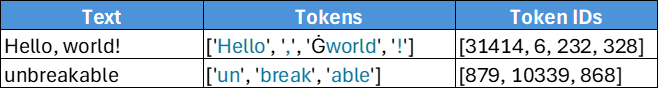
- `Dataset` creation: extracts numpy arrays from dataframes to create PyTorch `Dataset` objects with tokenizer.
- `DataLoader`: creates iterators for batches data, training data is shuffled for better learning. Memory efficiency.
- Train the model using training data and evaluate it on validation data. Save the best model state based on validation accuracy.
- Load the best-performing model state for inference in the next step

In [23]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


NVIDIA GeForce RTX 2080 Super with Max-Q Design


In [18]:
# Set random seed for reproducibility
torch.manual_seed(configs.randam_seed)
np.random.seed(configs.randam_seed)

# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained(configs.model_name)

# Create datasets
train_dataset = IntentDataset(train_texts, train_intents, tokenizer)
val_dataset = IntentDataset(val_texts, val_intents, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=configs.batch_size)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device {device}")
model = IntentClassifier(num_intent_classes=num_unique_intents)
model = model.to(device)

# Save the best model state
model_path = f'models/best_model.pth'
# ***** Train model
best_model_state, best_accuracy = train_model(model, train_loader, val_loader, device)

torch.save({
    'model_state_dict': best_model_state,
    'accuracy': best_accuracy,
    'model_config': model.config.to_dict(),  # Save RoBERTa config
}, model_path)

Device cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5: 100%|██████████| 409/409 [00:57<00:00,  7.08it/s]


Epoch 1: | Training Loss: 2.6601         | Training Accuracy: 0.3452         | Validation Accuracy: 0.9511


Epoch 2/5: 100%|██████████| 409/409 [00:59<00:00,  6.91it/s]


Epoch 2: | Training Loss: 0.4031         | Training Accuracy: 0.9674         | Validation Accuracy: 0.9939


Epoch 3/5: 100%|██████████| 409/409 [00:59<00:00,  6.82it/s]


Epoch 3: | Training Loss: 0.0543         | Training Accuracy: 0.9920         | Validation Accuracy: 0.9963


Epoch 4/5: 100%|██████████| 409/409 [01:00<00:00,  6.71it/s]


Epoch 4: | Training Loss: 0.0286         | Training Accuracy: 0.9956         | Validation Accuracy: 0.9976


Epoch 5/5: 100%|██████████| 409/409 [01:01<00:00,  6.66it/s]


Epoch 5: | Training Loss: 0.0182         | Training Accuracy: 0.9966         | Validation Accuracy: 0.9963


In [24]:
def load_model(model, save_path):
    if os.path.exists(save_path):
        # Load the saved state
        checkpoint = torch.load(save_path)

        # Load state dict into model
        model.load_state_dict(checkpoint['model_state_dict'])

        # Return the accuracy achieved
        return checkpoint['accuracy']
    else:
        print(f"No saved model found at {save_path}")
        return None

If the model is trained on CUDA and saved to a file, when it is loaded, it needs to run on CUDA (not CPU) ???

In [25]:
# Load best model
best_accuracy = load_model(model, model_path)
print(f"Loaded model with accuracy: {best_accuracy}")

Loaded model with accuracy: 0.9975550122249389


In [26]:
# Example prediction
# Get 10 random rows
random_rows = df_test_raw.sample(n=10)  # specifies 10 rows
for index, row in random_rows.iterrows():
    sample_text = row['utterance']
    predicted_intent = predict_intent(sample_text, model, tokenizer, label_encoder, device)
    result = predicted_intent == row['intent']
    print(f"'{sample_text}' \n  > Predicted intent: {predicted_intent} {'- CORRECT' if result else '- Incorrect'}\n")

'I can't subscribe to hte newsletter' 
  > Predicted intent: newsletter_subscription - CORRECT

'I need help to leave a review for your services' 
  > Predicted intent: review - CORRECT

'help me getting my invoices' 
  > Predicted intent: get_invoice - CORRECT

'I need help to solve a payment issue' 
  > Predicted intent: payment_issue - CORRECT

'I don't know what I need to do to switch user' 
  > Predicted intent: switch_account - CORRECT

'I do not know what to do to sign up to your newsletter' 
  > Predicted intent: newsletter_subscription - CORRECT

'I need information about the delivery options' 
  > Predicted intent: delivery_options - CORRECT

'could you help me to submit some feedback for your company?' 
  > Predicted intent: review - CORRECT

'would it be possible to check the status of the refund?' 
  > Predicted intent: track_refund - CORRECT

'I need assistance changing the shipping address' 
  > Predicted intent: change_shipping_address - CORRECT



## Text Augmentation
Text augmentation is a technique for generating additional training data by introducing linguistic diversity but maintaining semantic meaning. This is especially useful when your dataset is too small, imbalanced for tasks like intent classification, machine translation, and chatbot training.

As seen earlier, our dataset has already been augmented but we're going to take it a step further - augmenting data in our own ways to create entirely new samples and test them with our best-trained model.

A popular tool for this is `TextAttack`, a Python framework designed specifically for NLP data augmentation. If you've had trouble installing it, don't worry - you're not alone! In this article, I'll be implementing text augmentation from scratch, without using `TextAttack`, to show a hands-on approach that anyone can apply.

### 1. Synonym Replacement with Pre-trained Embeddings
One of the simplest ways to augment text is by swapping words with their synonyms. To do this effectively, we need a way to determine which words are truly similar. That’s where pre-trained word embeddings come in. In this project, I used GloVe — specifically, `glove.6B.100d.txt`. This file was trained on 6 billion tokens, and each word is represented as a 100-dimensional vector. With a vocabulary of 400,000 words, it gives us a solid foundation for finding words with similar meanings. Why use GloVe? Because it captures relationships between words based on how they appear in real-world text. If two words frequently show up in similar contexts, their vectors will be close together in the embedding space. This means we can identify the most similar words and use them as replacements to create new variations of our text data. You can try with alternatives of Glove, such as WordNet, FastText and BERT's masked language model.

In [ ]:
# from gensim.models import KeyedVectors  # cannot install gensim
# import spacy
from scipy.spatial.distance import cosine
import random

# Load GloVe vectors
def load_glove(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector  # embeddings['king'] = [-0.32307  -0.87616 ...]
    return embeddings

# Function to find most similar words, to replace KeyedVectors.most_similar()
def most_similar(word, embeddings, topn=3):
    if word not in embeddings:
        return []
    
    word_vector = embeddings[word]
    similarities = {}
    
    for other_word, other_vector in embeddings.items():
        if other_word == word:
            continue
        # Calculate cosine similarity (1 - cosine distance)
        similarity = 1 - cosine(word_vector, other_vector)
        similarities[other_word] = similarity
    
    # Sort by similarity and get top n
    return sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:topn]

# Load GloVe embeddings
glove_vectors = load_glove("glove/glove.6B.100d.txt")

# Convert to gensim KeyedVectors format
# vector_size = 100  # GloVe.6B.100d has 100-dimensional vectors
# glove = KeyedVectors(vector_size)

# # Add vectors to KeyedVectors
# glove.add_vectors(
#     keys=list(glove_vectors.keys()),  # List of words
#     weights=[glove_vectors[word] for word in glove_vectors.keys()]  # Corresponding vectors
# )

# Example usage: Find most similar words
# print(f"order: {glove.most_similar('order', topn=3)}")
# print(f"address: {glove.most_similar('address', topn=3)}")
# print(f"much: {glove.most_similar('much', topn=3)}")
print(f"order: {most_similar('order', glove_vectors, topn=3)}")
print(f"address: {most_similar('address', glove_vectors, topn=3)}")
print(f"much: {most_similar('much', glove_vectors, topn=3)}")


order: [('to', np.float32(0.7442451)), ('allow', np.float32(0.73785406)), ('take', np.float32(0.73154724))]
address: [('addressed', np.float32(0.8083333)), ('addressing', np.float32(0.78290296)), ('addresses', np.float32(0.7664799))]
much: [('even', np.float32(0.90359205)), ('more', np.float32(0.876028)), ('less', np.float32(0.8753514))]


In [ ]:
from nltk.tokenize import word_tokenize
import random

nltk.download('punkt_tab')  # instead of 'punkt' which is deprecated
# Add the path to the NLTK data directory
# nltk.data.path.append(r'C:\Users\fam2064\AppData\Roaming\nltk_data')

def synonym_replacement(text, glove_vectors):
    """
    Replace a random word (not a stopword) in the text with a synonym using GloVe embeddings.
    """
    # Tokenize the text
    words = word_tokenize(text)

    # Get English stopwords
    stop_words = set(stopwords.words('english'))

    # Find replaceable words (words that are in GloVe and not stopwords)
    replaceable_words = []
    for i, word in enumerate(words):
        if word.lower() in glove_vectors and word.lower() not in stop_words and word.isalnum():
            replaceable_words.append((i, word))

    # If no replaceable words found, return original text
    if not replaceable_words:
        return text

    # Select a random word to replace
    idx, word_to_replace = random.choice(replaceable_words)

    # Get synonyms from GloVe
    try:
        synonyms = most_similar(word_to_replace.lower(), glove_vectors, topn=3)
        # Choose a random synonym
        synonym = random.choice(synonyms)[0]

        # Replace the word while maintaining original case
        if word_to_replace.isupper():
            synonym = synonym.upper()
        elif word_to_replace[0].isupper():
            synonym = synonym.capitalize()

        # Create new text with the synonym
        words[idx] = synonym

    except KeyError:
        # If word not found in GloVe, return original text
        return text

    # Join the words back together
    return ' '.join(words)

# Example usage
texts = ["remove some items from an order",
         "can you tell me about updating the address?",
         "how much will you charge me if I break the contract?"]

augmented_texts = []
for text in texts:
    augmented_texts.append(synonym_replacement(text, glove_vectors))

print(augmented_texts)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\fam2064\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['removal some items from an order', 'can you tell me about rewriting the address ?', 'how less will you charge me if I break the contract ?']


For each utterance, I’ll randomly select a word (excluding common stop words like is, the, and a) and replace it with a synonym found using GloVe embeddings. The goal is to generate natural-sounding variations while preserving the original meaning.

Here are some examples of original and augmented texts:
- "remove some items from an order"
  * ❌Not good: *'removal some items from an order', 'remove some items from an take'*
  * ✅Good: *'remove some products from an order'*
- "can you tell me about updating the address?"
  * ❌Not good: *'can you tell me about updated the address ?', 'can you tell me about updating the speech ?'*
- "how much will you charge me if I break the contract?"
  * ❌Not good: *'how so will you charge me if I break the contract ?', 'how more will you charge me if I break the contract ?', 'how much will you charge me if I breaking the contract ?', 'how much will you charge me if I broke the contract ?'*
  * ✅Good: *'how much will you charge me if I break the agreement ?'*

Some substitutions work well, while many others sound unnatural due to incorrect grammar or word choice. Synonym replacement is not just about swapping words; it's about ensuring they fit naturally in the sentence, and we need to review the results to select only the good ones.

### 2. Back Translation

Another effective augmentation technique is back translation. The idea is straightforward: translate your text into another language and then translate it back to English. The slight shifts in wording during translation creates natural variations while preserving the original meaning.

Most implementations of back translation rely on `googletrans`, but the latest version requires `await` since the translate method is now asynchronous. I wanted a more straightforward, synchronous solution, so I went with `deep_translator`-a more stable alternative that gets the job done without dealing with async calls.

In [ ]:
# !pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 4.0 MB/s eta 0:00:00


In [ ]:
from deep_translator import GoogleTranslator

def back_translation(text, intermediate_lang1='fr', intermediate_lang2='de', intermediate_lang3='es'): # intermediate_lang2='vi', intermediate_lang3='id'
    # Initialize translators
    to_intermediate1 = GoogleTranslator(source='en', target=intermediate_lang1)
    to_intermediate2 = GoogleTranslator(source=intermediate_lang1, target=intermediate_lang2)
    to_intermediate3 = GoogleTranslator(source=intermediate_lang2, target=intermediate_lang3)
    to_english = GoogleTranslator(source=intermediate_lang3, target='en')

    # Translate to intermediate language
    translated1 = to_intermediate1.translate(text)
    translated2 = to_intermediate2.translate(text)
    translated3 = to_intermediate3.translate(text)
    # Translate back to English
    back_translated = to_english.translate(translated3)
    return back_translated

# Example usage
texts = ["remove some items from an order",
         "can you tell me about updating the address?",
         "how much will you charge me if I break the contract?"]

augmented_texts = []
for text in texts:
    augmented_texts.append(back_translation(text))

print(augmented_texts)

['Remove some articles from an order', 'Can you tell me about the address update?', 'How much do you want you to charge me if I break the contract?']


Initially, I tried French and German as intermediate languages, but the results were identical to the original text. To introduce more variation, I experimented with 3 intermediate languages in different "pipelines", and the results were more diverse. Check them out below:

**Original Utterances:**

- "Remove some items from an order"
- "Can you tell me about updating the address?"
- "How much will you charge me if I break the contract?"

**Translated Pipelines & Results:**

1️⃣ English → Dutch → Vietnamese → Indonesian → English:
 "Delete a few items from the order", "Can you tell me about updating the address?", "How much will you collect me if I break the contract?"

2️⃣ English → French → German → Spanish → English:
 "Remove some articles from an order", "Can you tell me about the address update?", "How much do you want you to charge me if I break the contract?"

3️⃣ English → Dutch → Japanese → French → English:
 "Delete certain elements of an order", "Can you tell me about updating the address?", "How much will you charge me if I break the contract?"

One thing to notice here is that **using too many translation steps or less common languages** can sometimes distort the meaning beyond what’s useful.

Overall, back translation is simple and effective. I found it to be one of the best augmentation techniques out there. Give it a try and see how it works for you!

### 3. Pattern-Based Question Augmentation
This method focuses on restructuring question patterns while preserving their original intent. It utilizes regex-based pattern mapping to generate semantically equivalent variations, enhancing the model's ability to recognize diverse inquiry formats.

For example, let's say our dataset includes:
- "How much would you charge for terminating the contract?"
- "How much do you charge for terminating the contract?"

A regex-based augmentation approach could generate new variations, such as:
- "What would be the cost of terminating the contract?"
- "I'd like to know the cost of terminating the contract."

In [41]:
import random
import re
from typing import List, Tuple


# Expanded patterns with more variations
question_patterns = {
    # How much patterns
    r'\b(how much (would|will|do) you charge)\b': [
        "what's the fee for",
        "what would be the cost for",
        "could you tell me the price for",
        "what are the charges associated with",
        "I'd like to know the cost for",
        "what's the financial penalty for",
        "what would I have to pay for",
        "can you provide the fee details for"
    ],
    r'\b(can you|could you)\b': [
        "would you be able to",
        "is it possible to",
        "I'd like to know if you can",
        "would it be possible to",
        "are you able to",
        "I was wondering if you could"
    ],
    r'\b(how do i|how can i|how to)\b': [
        "what's the process to",
        "what are the steps to",
        "could you guide me on how to",
        "what's the best way to",
        "please explain how to",
        "I need help to"
    ],
}

def question_reformation(text: str, num_variations: int = 3) -> List[str]:
    """
    Reformulate questions in different ways, considering intent if provided.
    Returns a list of reformulated questions.
    """
    reformulations = []

    # Try general question reformulation
    for pattern, replacements in question_patterns.items():
        matches = re.finditer(pattern, text.lower())
        for match in matches:
            # Get random unique replacements
            selected_replacements = random.sample(replacements, \
                                    min(num_variations, len(replacements)))
            for replacement in selected_replacements:
                new_text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
                reformulations.append(new_text)

    # If no reformulations were possible, return original text
    if not reformulations:
        reformulations = [text]

    # Remove duplicates while preserving order
    return list(dict.fromkeys(reformulations))

# Example texts with intents
examples = [
    "how much will you charge me if I break the contract?",
    "can you tell me about updating the address?",
    "how do I check your allowed payment methods?"
]

for text in examples:
    print(f"\nOriginal: {text}")
    print("Reformulations:")
    reformulations = question_reformation(text)
    for i, ref in enumerate(reformulations, 1):
        print(f"{i}. {ref}")


Original: how much will you charge me if I break the contract?
Reformulations:
1. what would I have to pay for me if I break the contract?
2. what's the fee for me if I break the contract?
3. could you tell me the price for me if I break the contract?

Original: can you tell me about updating the address?
Reformulations:
1. would you be able to tell me about updating the address?
2. would it be possible to tell me about updating the address?
3. is it possible to tell me about updating the address?

Original: how do I check your allowed payment methods?
Reformulations:
1. what are the steps to check your allowed payment methods?
2. what's the process to check your allowed payment methods?
3. what's the best way to check your allowed payment methods?


In [42]:

texts = [
    'remove some products from an order',
    'Remove some articles from an order',
    'Delete a few items from the order',
    'is it possible to tell me about updating the address?',
    'Can you tell me about the address update?',
    'Can you tell me about updating the delivery location?',
    'what would be the cost for me if I break the contract?',
    'how much will you charge me if I break the agreement ?',
    'How much do you want you to charge me if I terminate the contract?',
    'How much will you collect me if I break the contract?'
]

for text in texts:
    predicted_intent = predict_intent(text, model, tokenizer, label_encoder, device)
    print(f"'{text}'   > Predicted intent: {predicted_intent}\n")

'remove some products from an order'   > Predicted intent: change_order

'Remove some articles from an order'   > Predicted intent: change_order

'Delete a few items from the order'   > Predicted intent: change_order

'is it possible to tell me about updating the address?'   > Predicted intent: change_shipping_address

'Can you tell me about the address update?'   > Predicted intent: change_shipping_address

'Can you tell me about updating the delivery location?'   > Predicted intent: change_shipping_address

'what would be the cost for me if I break the contract?'   > Predicted intent: check_cancellation_fee

'how much will you charge me if I break the agreement ?'   > Predicted intent: check_cancellation_fee

'How much do you want you to charge me if I terminate the contract?'   > Predicted intent: check_cancellation_fee

'How much will you collect me if I break the contract?'   > Predicted intent: check_cancellation_fee



## References
- Dataset: https://www.kaggle.com/datasets/scodepy/customer-support-intent-dataset/data